In [10]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/tweets.csv


## Libraries

In [40]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [12]:
tweetds = pd.read_csv('/kaggle/input/disaster-tweets/tweets.csv')
tweetds.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [13]:
tweetds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [14]:
tweetds.describe(include='all')

,id,keyword,location,text,target
count,11370.000000,11370,7952,11370,11370.000000
unique,NaN,219,4504,11223,NaN
top,NaN,thunderstorm,United States,I want to help you with my project to save the...,NaN
freq,NaN,93,96,3,NaN
mean,5684.500000,NaN,NaN,NaN,0.185928
std,3282.380615,NaN,NaN,NaN,0.389066
min,0.000000,NaN,NaN,NaN,0.000000
25%,2842.250000,NaN,NaN,NaN,0.000000
50%,5684.500000,NaN,NaN,NaN,0.000000
75%,8526.750000,NaN,NaN,NaN,0.000000


## Data Cleaning

In [15]:
# stopwords
try:
  stop_words = set(stopwords.words("english"))
except:
  nltk.download('stopwords')
  stop_words = set(stopwords.words("english"))

# remove the stopwords and single-character words
def remove_sw_and_sc(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words and len(i) > 1:
            final_text.append(i.strip())
    return " ".join(final_text)

In [16]:
# clean text function
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub('https?://\S+', '', text) # remove url
    text = re.sub('<.*?>', '', text) # remove html tags
    text = re.sub('&\S+?;', '', text) # remove html entities
    text = re.sub(r'@\S+', '', text) # remove mention
    text = re.sub('[^\w\s]+', '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\d+', '', text) # remove numbers
    # text = stemmer.stem(text) # stemming
    text = text.strip() # remove whitespace
    return text

# source https://www.kaggle.com/code/masatoshikato/effective-eda-bert-in-nlp-bert-baseline
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' emoji ', string)

In [17]:
X, y = tweetds['text'], tweetds['target']

X = X.apply(clean_text)
X = X.apply(lambda text: remove_emoji(text))
X = X.apply(remove_sw_and_sc)

In [18]:
X.sample(5).values

array(['video elderly woman filmed riding mobility scooter roadway kamloops snowstorm kamloops bcstorm',
       'let worlds collide',
       'fromoneline felt earth move palpable chemistry right eyes first met two worlds collided',
       'per cent spinal cord injury patients poor',
       'sour patch kids commercial gonna drown mother frame last second well come'],
      dtype=object)

## EDA

In [19]:
tweet_desc = tweetds[['text', 'target']]
tweet_desc.text.sample(10).values

array(['Greens policy platform supports hazard reduction. Check it. Greens comprise less th… https://t.co/ohmpPlo8CQ',
       'Have spent the last couple of days in the tiny communities devastated by the megablaze on the NSW/Vic border. The damage…',
       'i used to be cool :(',
       'He sounds like an absolute dickhead. "He pissed me off twice and nearly injured my shoulder BC he can… https://t.co/cdbhXZtLA5',
       "Now I can see that the VIC is back. The TL gets blazing🔥🔥🔥 when you're around. Happy 2020 to you #Leadership!",
       'Fake News: Virginia Governor NOT Preparing To Order Up To 10,000 Body Bags In Anticipation Of Civil War… https://t.co/ltUjyanlJU',
       'Several prominent Iranian state television and radio hosts have quite their jobs, "saying they could no longer lie for the gov…',
       '. says he has learned lesson, vows to stay out of trouble https://t.co/B6GijJjcXI',
       "It's hard to have conversations about things we like, dislike, or have all around cr

In [20]:
# Hashtag
tweet_desc['hashtags'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Mention
tweet_desc['mention'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

# Punctuation
def count_punct(text):
    # transform a html entity to count as a symbol
    text = re.sub('&\S+?;', '&', text)
    # count punctuation
    count = sum([1 for char in text if char in string.punctuation])
    return count

tweet_desc['punctuation'] = tweet_desc['text'].apply(lambda x: count_punct(x))
# hashtags and mentions don't count as punctuation
tweet_desc['punctuation'] -= tweet_desc['hashtags'] + tweet_desc['mention']

# Numbers / Digits
tweet_desc['numerics'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

# di bawah ini, symbol, html tags & entities, dan url terhitung juga? kalau gak cleaning dulu

# Number of Words
tweet_desc['word_count'] = tweet_desc['text'].apply(lambda x: len(str(x).split(" ")))

# Number of Character
tweet_desc['char_count'] = tweet_desc['text'].str.len()

tweet_desc.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,target,hashtags,mention,punctuation,numerics,word_count,char_count
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1,0,0,4,0,19,125
1,Telangana: Section 144 has been imposed in Bha...,1,0,0,3,2,23,131
2,Arsonist sets cars ablaze at dealership https:...,1,0,0,5,0,7,63
3,Arsonist sets cars ablaze at dealership https:...,1,0,0,10,0,8,87
4,"""Lord Jesus, your love brings freedom and pard...",0,0,0,8,0,23,140


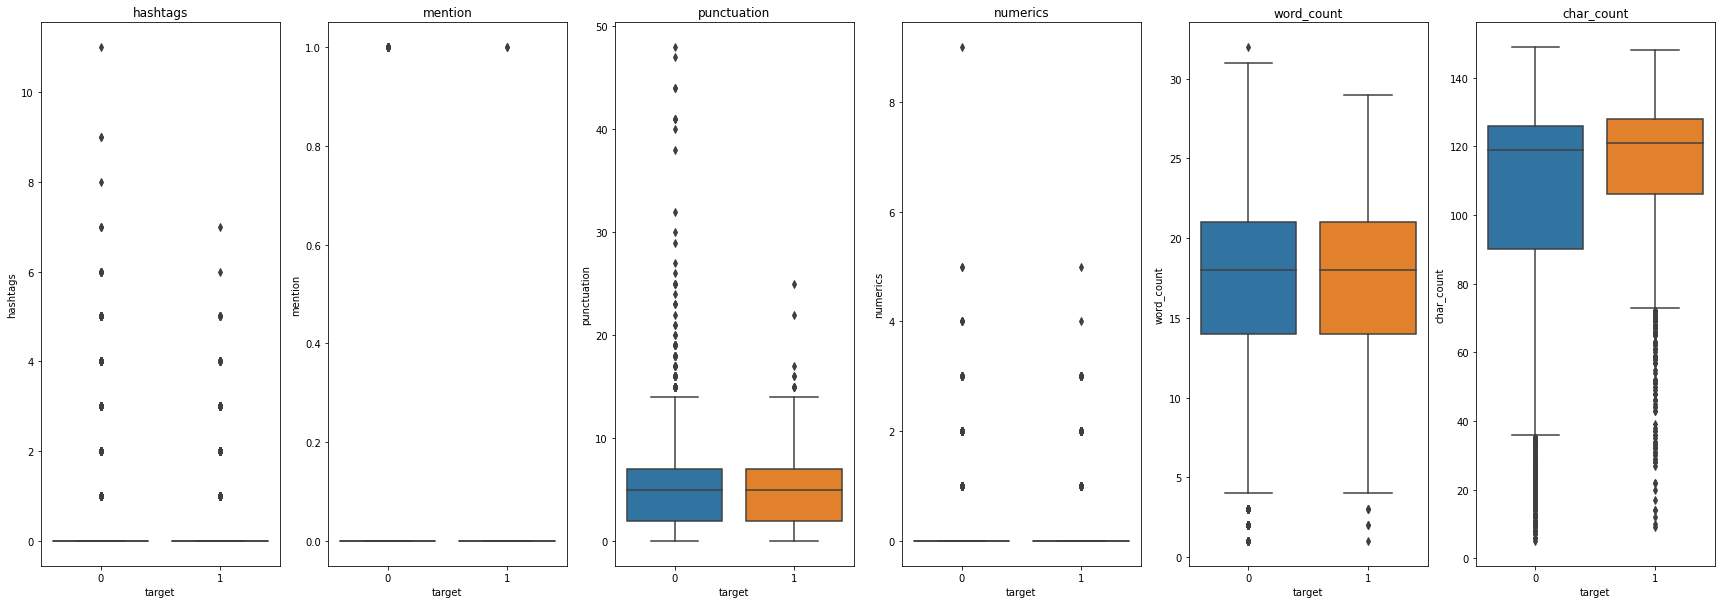

In [21]:
# boxplot
num_columns = tweet_desc.columns[2:]

plt.figure(figsize=(30, 10))
for ind, col in enumerate(num_columns):
    plt.subplot(1, 6, ind+1)
    sns.boxplot(data=tweet_desc, y=col, x='target')
    plt.title(col)
plt.show()

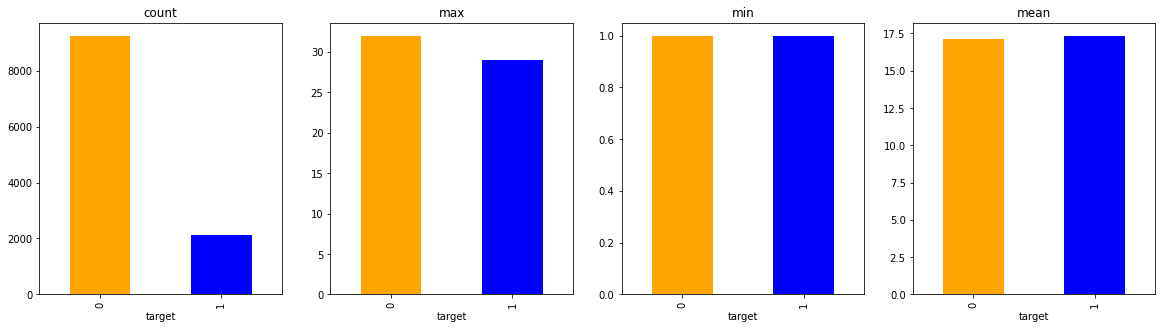

In [22]:
# word count stats
stats = tweet_desc.groupby(['target']).agg(['count', 'max', 'min', 'mean']).word_count.T

plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    stats.iloc[i].plot.bar(color=['orange', 'blue'])
    plt.title(stats.iloc[i].name)
plt.show()

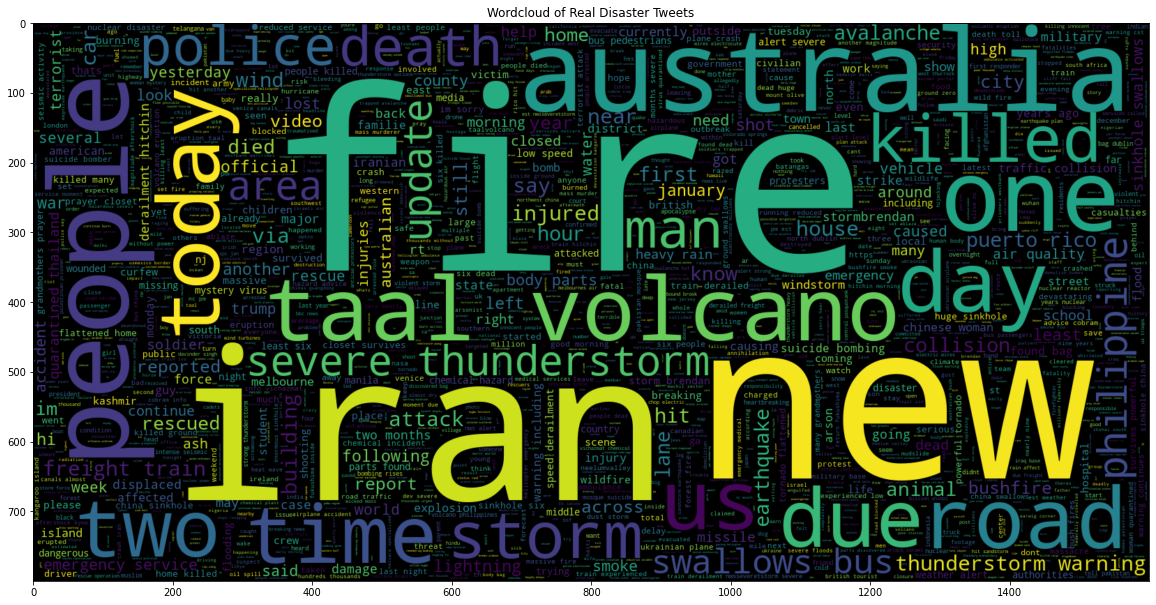

In [23]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(X[y == 1]))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Wordcloud of Real Disaster Tweets")
plt.show()

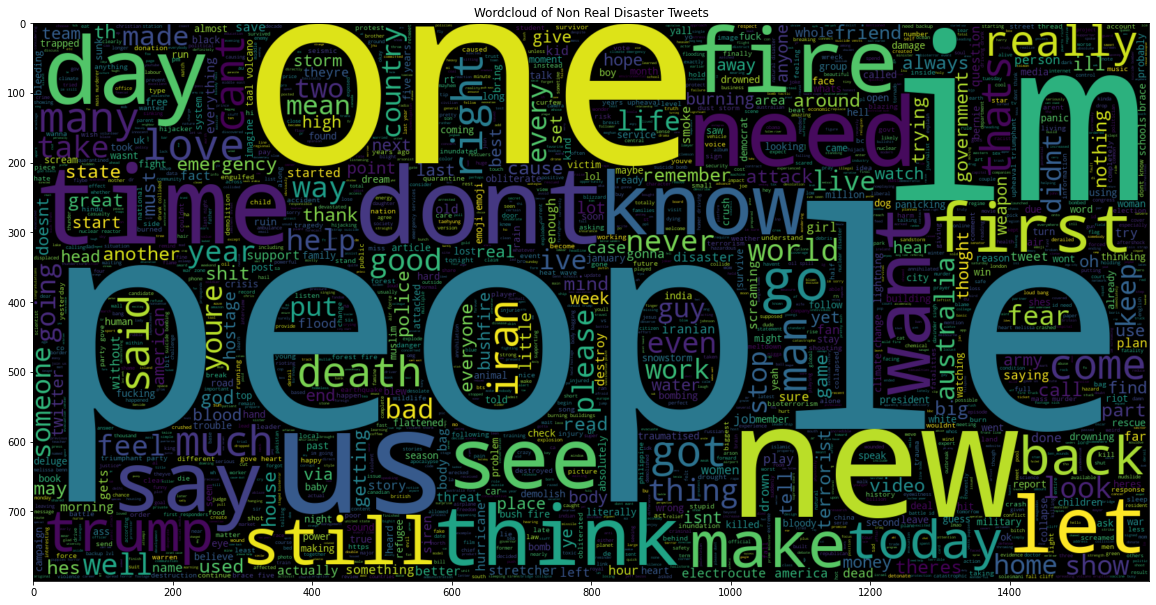

In [24]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(X[y == 0]))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Wordcloud of Non Real Disaster Tweets")
plt.show()

## Pre-processing Data

### Split Train and Test Data

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=4, shuffle=True)

### Embeddings

In [26]:
# split sentence to word
X_train = X_train.apply(word_tokenize)

In [27]:
EMBEDDING_DIM = 300

w2v = Word2Vec(sentences=X_train, vector_size=EMBEDDING_DIM, window=7, min_count=1, sg=1)
w2v.train(X_train, total_examples=len(X_train), epochs=10)

(746674, 751570)

In [28]:
len(w2v.wv.key_to_index)

17521

In [29]:
def get_weight_matrix(weight_matrix, model, vocab):
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

### Tokenizer

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

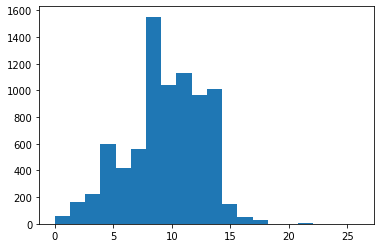

In [31]:
plt.hist([len(x) for x in X_train], bins=20)
plt.show()

In [32]:
maxlen = 20

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [33]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # Add 1 because of reserved 0 index
vocab_size

17522

In [34]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
embedding_matrix = get_weight_matrix(embedding_matrix, w2v.wv.key_to_index, word_index)

## Model

In [42]:
callbacks = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)

### Global Max

In [46]:
#Defining Neural Network
modelGM = Sequential()
#Non-trainable embedding layer
modelGM.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelGM.add(GlobalMaxPooling1D())
modelGM.add(Dense(128, activation='relu'))
modelGM.add(Dense(64, activation='relu'))
modelGM.add(Dense(1, activation='sigmoid'))

modelGM.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelGM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 300)           5256600   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 5,303,449
Trainable params: 46,849
Non-trainable params: 5,256,600
_________________________________________________________________


In [47]:
historyGM = modelGM.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 1s 6ms/step - loss: 1046.3950 - acc: 0.6995 - val_loss: 39.4174 - val_acc: 0.8168
Epoch 2/25
125/125 [==============================] - 1s 4ms/step - loss: 21.3526 - acc: 0.6993 - val_loss: 6.2640 - val_acc: 0.8159
Epoch 3/25
125/125 [==============================] - 1s 4ms/step - loss: 2.5913 - acc: 0.7770 - val_loss: 0.5214 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 1s 4ms/step - loss: 0.5053 - acc: 0.8118 - val_loss: 0.4963 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 1s 4ms/step - loss: 0.4880 - acc: 0.8118 - val_loss: 0.4907 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 1s 4ms/step - loss: 0.4845 - acc: 0.8118 - val_loss: 0.4837 - val_acc: 0.8194
Epoch 7/25
125/125 [==============================] - 1s 4ms/step - loss: 0.4820 - acc: 0.8118 - val_loss: 0.4772 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 1s 4ms/step - los

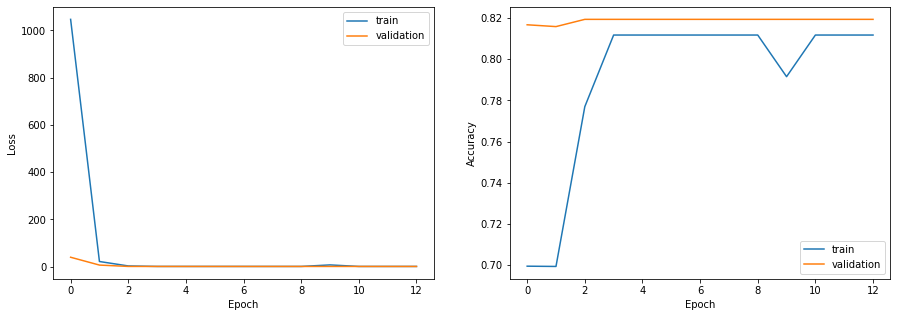

In [72]:
metrics = pd.DataFrame(historyGM.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()


### Global Average

In [73]:
#Defining Neural Network
modelGA = Sequential()
#Non-trainable embedding layer
modelGA.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelGA.add(GlobalAveragePooling1D())
modelGA.add(Dense(128, activation='relu'))
modelGA.add(Dense(64, activation='relu'))
modelGA.add(Dense(1, activation='sigmoid'))

modelGA.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelGA.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 300)           5256600   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 5,303,449
Trainable params: 46,849
Non-trainable params: 5,256,600
_________________________________________________________________


In [74]:
historyGA = modelGA.fit(X_train,
                      y_train,
                      batch_size=64,
                      validation_data=(X_val,y_val),
                      epochs=25,
                      callbacks=callbacks,
                      verbose=1)

Epoch 1/25
125/125 [==============================] - 1s 6ms/step - loss: 215.8714 - acc: 0.6953 - val_loss: 10.3138 - val_acc: 0.8159
Epoch 2/25
125/125 [==============================] - 1s 5ms/step - loss: 1.4252 - acc: 0.7532 - val_loss: 0.5579 - val_acc: 0.8194
Epoch 3/25
125/125 [==============================] - 1s 5ms/step - loss: 0.5090 - acc: 0.8118 - val_loss: 0.5200 - val_acc: 0.8194
Epoch 4/25
125/125 [==============================] - 1s 5ms/step - loss: 0.5309 - acc: 0.8064 - val_loss: 0.5115 - val_acc: 0.8194
Epoch 5/25
125/125 [==============================] - 1s 5ms/step - loss: 0.4980 - acc: 0.8112 - val_loss: 0.4950 - val_acc: 0.8194
Epoch 6/25
125/125 [==============================] - 1s 5ms/step - loss: 0.4847 - acc: 0.8118 - val_loss: 0.4805 - val_acc: 0.8194
Epoch 7/25
125/125 [==============================] - 1s 5ms/step - loss: 0.4825 - acc: 0.8118 - val_loss: 0.4784 - val_acc: 0.8194
Epoch 8/25
125/125 [==============================] - 1s 5ms/step - loss:

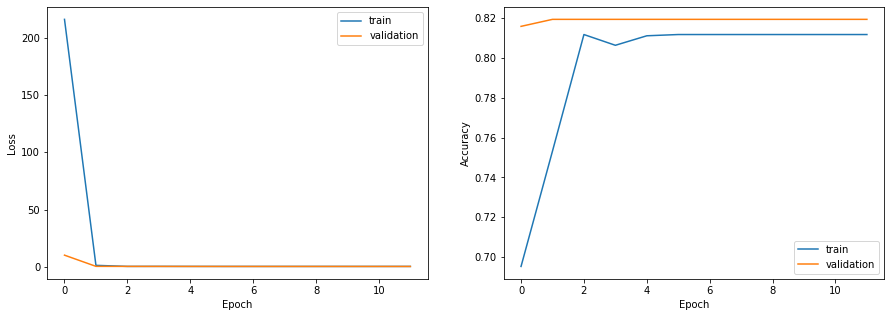

In [75]:
metrics = pd.DataFrame(historyGA.history)

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.plot(metrics.index, metrics.loss, label = "train")
ax1.plot(metrics.index, metrics.val_loss, label = "validation")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(metrics.index, metrics.acc, label = "train")
ax2.plot(metrics.index, metrics.val_acc, label = "validation")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.legend()

plt.show()

# OTAK ATIK KODE
abaikan saja

In [ ]:
wweweqweqweqw

In [ ]:
from keras.layers import MaxPooling1D, AveragePooling1D

### Max

In [ ]:
#Defining Neural Network
modelM = Sequential()
#Non-trainable embedding layer
modelM.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelM.add(MaxPooling1D())
modelM.add(Dense(128, activation='relu'))
modelM.add(Dense(64, activation='relu'))
modelM.add(Dense(1, activation='sigmoid'))

modelM.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelM.summary()

In [ ]:
history = modelM.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    validation_data=(X_val,y_val), 
                    epochs=10, 
                    verbose=1)

### Average

In [ ]:
#Defining Neural Network
modelA = Sequential()
#Non-trainable embedding layer
modelA.add(Embedding(vocab_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

modelA.add(AveragePooling1D())
modelA.add(Dense(128, activation='relu'))
modelA.add(Dense(64, activation='relu'))
modelA.add(Dense(1, activation='sigmoid'))

modelA.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['acc'])
modelA.summary()

In [ ]:
history = modelA.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    validation_data=(X_val,y_val), 
                    epochs=10, 
                    verbose=1)

### Bert

In [ ]:
import tensorflow_hub as hub

In [ ]:
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train,))
data_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
# model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
label_list = [0, 1] # Label categories
max_seq_length = 40 # maximum length of (token) input sequences
batch_size = 32

In [ ]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a = text.numpy(), text_b=None, label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
def map_feature(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [ ]:
data_train = (data_train.map(map_feature, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .shuffle(1000, seed=4)
                      .batch(batch_size, drop_remainder=False)
                      .prefetch(tf.data.experimental.AUTOTUNE))

data_val = (data_val.map(map_feature, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                      .batch(batch_size, drop_remainder=False)
                      .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
def create_model(max_seq_length):
  input_word_ids = Input(shape=(max_seq_length, ), dtype=tf.int32, name="input_word_ids")
  input_mask = Input(shape=(max_seq_length, ), dtype=tf.int32, name="input_mask")
  input_type_ids = Input(shape=(max_seq_length, ), dtype=tf.int32, name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  # output = bert_layer([input_word_ids, input_mask, input_type_ids])
  # pooled_output = output['pooled_output']
  output = pooled_output

  # output = tf.keras.layers.Dropout(0.3)(output)
  output = Dense(1, activation="sigmoid", name="finale_output")(output)

  model = Model( inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

In [ ]:
modelbert = create_model(max_seq_length)
modelbert.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=["accuracy", Precision(), Recall()])
modelbert.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint('bert_model.h5', monitor='val_accuracy', save_best_only=True)

callbacks = [checkpoint]

history = modelbert.fit(X_train, y_train,
                    validation_data=(X_val,y_val), 
                    epochs=5, callbacks=callbacks,
                    verbose=1
                    )

### Bert 2

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
classifier_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001, 
                                                              beta_1=0.9, beta_2=0.999, epsilon=1e-07), loss=loss, metrics=metrics)

In [ ]:
def build_classifier_model():
  text_input = Input(shape=(), dtype=tf.string, name='text')
  processing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocess_text')
  encoder_input = processing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BertEncoders')
  outputs = encoder(encoder_input)
  net = outputs['pooled_output']
  # sequence_output =  outputs['sequence_output']
  # net = sequence_output[:, 0, :]
  net = Dense(32, activation= 'relu')(net)
  net = Dropout(.1)(net)
  net = Dense(1, activation='sigmoid', name='classifier')(net)
  return Model(text_input, net)

In [ ]:
history = classifier_model.fit(x=X_train,y=y_train,  validation_data = (X_test, y_test), epochs = 32,batch_size=64, callbacks=callbacks)